In [ ]:
# загрузка пакетов: инструменты -------------------------------------------- # работа с массивами
import numpy as np
# фреймы данных
import pandas as pd
# графики
import matplotlib as mpl
# стили и шаблоны графиков на основе matplotlib
import seaborn as sns
# перекодировка категориальных переменных
from sklearn.preprocessing import LabelEncoder
# тест Шапиро-Уилка на нормальность распределения
from scipy.stats import shapiro
# для таймера
import time
# загрузка пакетов: модели ------------------------------------------------- # линейные модели
import sklearn.linear_model as skl_lm
# расчёт MSE
from sklearn.metrics import mean_squared_error
#  кросс-валидация
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
# константы
# ядро для генератора случайных чисел
my_seed = 11
# создаём псевдоним для короткого обращения к графикам
plt = mpl.pyplot
# настройка стиля и отображения графиков
# примеры стилей и шаблонов графиков:
# http://tonysyu.github.io/raw_content/matplotlib-style-gallery/gallery.html mpl.style.use('seaborn-whitegrid')
mpl.style.use('seaborn-whitegrid')
sns.set_palette("Set2")
# раскомментируйте следующую строку, чтобы посмотреть палитру
#sns.color_palette("Set2")

<ipython-input-194-992ee6c2a19d>:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn-whitegrid')


In [ ]:
# читаем таблицу из файла .csv во фрейм
fileURL = 'https://raw.githubusercontent.com/ania607/ML/main/data/Carseats.csv'

DF_raw = pd.read_csv(fileURL)
# выясняем размерность фрейма
print('Число строк и столбцов в наборе данных:\n', DF_raw.shape)

Число строк и столбцов в наборе данных:
 (400, 11)


In [ ]:
# количество пропусков
DF_raw.isna().sum()

Sales          0
CompPrice      0
Income         0
Advertising    0
Population     0
Price          0
ShelveLoc      0
Age            0
Education      0
Urban          0
US             0
dtype: int64

In [ ]:
# ShelveLoc/ качество стеллажа для размещения автокресел в каждом магазине: Плохое, Хорошее и Среднее
DF_raw['ShelveLoc'].unique()


array(['Bad', 'Good', 'Medium'], dtype=object)

In [ ]:
df_dummy = pd.get_dummies(DF_raw[['ShelveLoc']], drop_first=True)
df_dummy.head(5)

,ShelveLoc_Good,ShelveLoc_Medium
0,False,False
1,True,False
2,False,True
3,False,True
4,False,False


In [ ]:
DF_all = pd.concat([DF_raw.reset_index(drop=True), df_dummy], axis=1)
DF_all = DF_all[['Sales', 'Population', 'Price', 'ShelveLoc', 'ShelveLoc_Good','ShelveLoc_Medium']]
DF_all

,Sales,Population,Price,ShelveLoc,ShelveLoc_Good,ShelveLoc_Medium
0,9.50,276,120,Bad,False,False
1,11.22,260,83,Good,True,False
2,10.06,269,80,Medium,False,True
3,7.40,466,97,Medium,False,True
4,4.15,340,128,Bad,False,False
...,...,...,...,...,...,...
395,12.57,203,128,Good,True,False
396,6.14,37,120,Medium,False,True
397,7.41,368,159,Medium,False,True
398,5.94,284,95,Bad,False,False


In [ ]:
# данные для построения моделей
DF = DF_all.sample(frac = 0.8, random_state = my_seed)
# данные для прогнозов
DF_predict = DF_all.drop(DF.index)

In [ ]:
del DF_raw

**<h4>Предварительный анализ данных</h4>**

In [ ]:
DF[['Sales', 'Population', 'Price']].describe()

,Sales,Population,Price
count,320.000000,320.000000,320.000000
mean,7.631656,266.381250,116.590625
std,2.870417,146.628072,23.563519
min,0.000000,10.000000,24.000000
25%,5.557500,139.000000,100.750000
50%,7.565000,274.000000,118.500000
75%,9.452500,394.500000,131.000000
max,16.270000,509.000000,191.000000


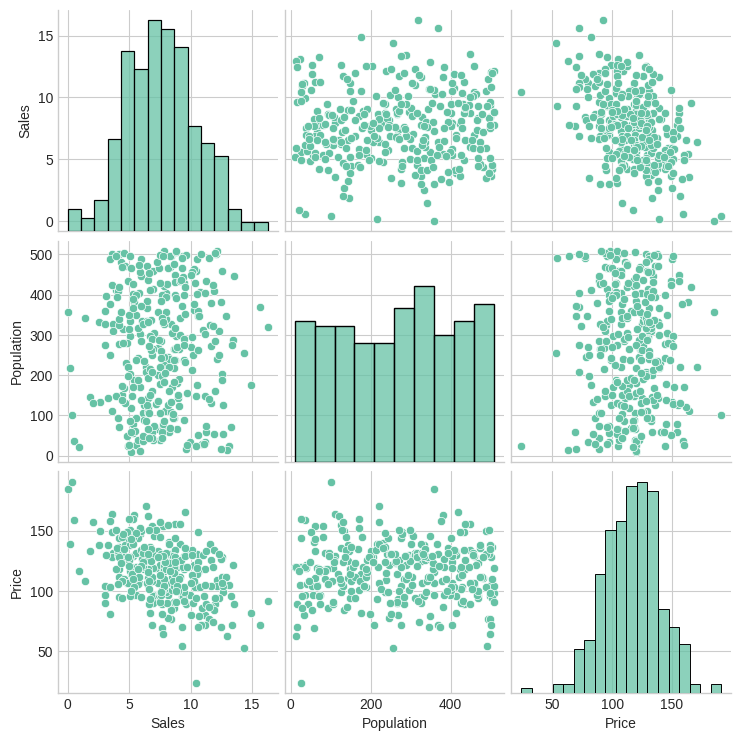

In [ ]:
sns.pairplot(DF[['Sales', 'Population', 'Price']])
plt.show()

Судя по графикам:

*   Распределение зависимой переменной sales приближено к нормальному распределению
*   Из всех объясняющих переменных, ни одна не распределена нормально



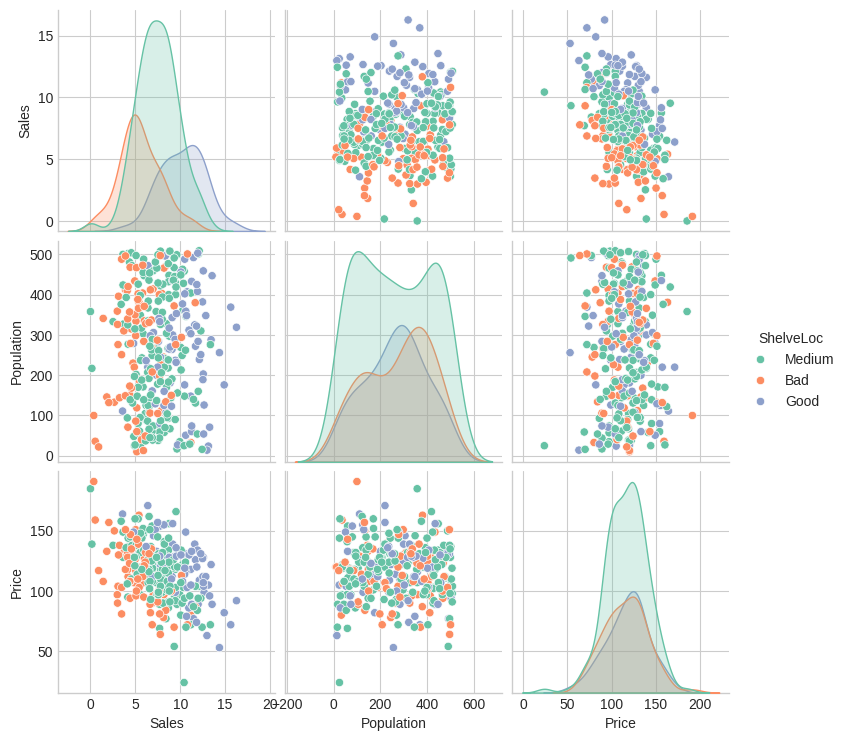

In [ ]:
sns.pairplot(DF[['Sales', 'Population', 'Price','ShelveLoc']], hue='ShelveLoc')
plt.show()

Если изучить графики разброса, можно предположить, что при повышении качества стеллажа для размещения автокресел (фиктивная ShelveLoc) могут расти цены на сами автокресла. Однако, можно также заметить из обычных графиков распределения, что пользуются спросом в основном автокресла, размещенные на стеллажах среднего качества

Посмотрим на корреляционные матрицы переменных фрейма.

In [ ]:
corr_mat = DF[['Sales', 'Population', 'Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Sales,Population,Price
Sales,1.000000,0.040494,-0.448894
Population,0.040494,1.000000,-0.022547
Price,-0.448894,-0.022547,1.000000


Без разбиения на классы наблюдений по фиктивным переменным максимальная теснота линейной взаимосвязи соответствует коэффициенту корреляции -0.45 между price и sales. Посчитаем корреляционные матрицы в зависимости от Shelveloc.

In [ ]:
corr_mat = DF.loc[DF['ShelveLoc'] == 'Medium'][['Sales', 'Population', 'Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Sales,Population,Price
Sales,1.000000,0.025313,-0.543982
Population,0.025313,1.000000,0.039581
Price,-0.543982,0.039581,1.000000


In [ ]:
corr_mat = DF.loc[DF['ShelveLoc'] == 'Good'][['Sales', 'Population', 'Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Sales,Population,Price
Sales,1.000000,0.065175,-0.661665
Population,0.065175,1.000000,-0.045216
Price,-0.661665,-0.045216,1.000000


In [ ]:
corr_mat = DF.loc[DF['ShelveLoc'] == 'Bad'][['Sales', 'Population', 'Price']].corr()
corr_mat.style.background_gradient(cmap='coolwarm')

,Sales,Population,Price
Sales,1.000000,0.158978,-0.532458
Population,0.158978,1.000000,-0.131973
Price,-0.532458,-0.131973,1.000000


Можно увидеть, что корреляция между price и sales увеличивается с учетом фиктивной переменной ShelveLoc.

Проверим sales на нормальность

In [ ]:
stat, p = shapiro(DF['Sales'])
print('sales', 'Statistics=%.2f, p=%.4f' % (stat, p)) # интерпретация
alpha = 0.05
if p > alpha:
    print('Распределение нормально (H0 не отклоняется)\n')
else:
    print('Распределение не нормально (H0 отклоняется)\n')

sales Statistics=0.99, p=0.3551
Распределение нормально (H0 не отклоняется)



**Строим модели регрессии**


По итогам предварительного анализа данных можно предложить следующие спецификации линейных регрессионных моделей:


*   Sales = a0 + a1 * Population + a2 * Price
*   Sales = a0 + a1 * Population + a2 * Price * ShelveLoc_Medium
*   Sales = a0 + a1 * Population + a2 * Price * ShelveLoc_Good




Создаём матрицы значений объясняющих переменных (X) и вектора значений зависимой (y) для всех моделей

In [ ]:
# 1
df1 = DF[['Sales', 'Population', 'Price']]
#2
df2 = DF[['Sales', 'Population', 'ShelveLoc_Medium', 'Price']]
df2.loc[:, 'Price_ShelveLoc_Medium'] = df2.loc[:, 'Price'] * df2.loc[:, 'ShelveLoc_Medium']
df2 = df2.drop(['ShelveLoc_Medium','Price'], axis=1)

#3
df3 = DF[['Sales', 'ShelveLoc_Good','Population', 'Price']]
df3.loc[:, 'Price_ShelveLoc_Good'] = df3.loc[:, 'Price'] * df3.loc[:, 'ShelveLoc_Good']
df3 = df3.drop(['Price', 'ShelveLoc_Good'], axis=1)

<ipython-input-210-d1fb3a0a1d4c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.loc[:, 'Price_ShelveLoc_Medium'] = df2.loc[:, 'Price'] * df2.loc[:, 'ShelveLoc_Medium']
<ipython-input-210-d1fb3a0a1d4c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3.loc[:, 'Price_ShelveLoc_Good'] = df3.loc[:, 'Price'] * df3.loc[:, 'ShelveLoc_Good']


In [ ]:
lm = skl_lm.LinearRegression()
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_0 = lm.fit(X, y)
print('модель 1','константа ', np.around(fit_lm_0.intercept_, 3), '\n объясняющие ', list(X.columns.values),'\n коэффициенты ', np.around(fit_lm_0.coef_, 3))

модель 1 константа  [13.839] 
 объясняющие  ['Population', 'Price'] 
 коэффициенты  [[ 0.001 -0.055]]


In [ ]:
y_pred = fit_lm_0.predict(X)
MSE1 = sum((y - y_pred.reshape(-1, 1))**2) / len(y)
MSE1

array([6.55088244])

In [ ]:
lm2 = skl_lm.LinearRegression()
X2 = df2.drop(['Sales'], axis=1)
y2 = df2.Sales.values.reshape(-1, 1)
fit_lm_2 = lm.fit(X2, y2)
print('модель 2','константа ', np.around(fit_lm_2.intercept_, 3), '\n объясняющие ', list(X2.columns.values),'\n коэффициенты ', np.around(fit_lm_2.coef_, 3))

модель 2 константа  [7.833] 
 объясняющие  ['Population', 'Price_ShelveLoc_Medium'] 
 коэффициенты  [[ 0.001 -0.007]]


In [ ]:
y_pred2 = fit_lm_2.predict(X2)
MSE2 = sum((y2 - y_pred2.reshape(-1, 1))**2) / len(y2)
MSE2

array([8.03396747])

In [ ]:
lm3 = skl_lm.LinearRegression()
X3 = df3.drop(['Sales'], axis=1)
y3 = df3.Sales.values.reshape(-1, 1)
fit_lm_3 = lm.fit(X3, y3)
print('модель 3','константа ', np.around(fit_lm_3.intercept_, 3), '\n объясняющие ', list(X3.columns.values),'\n коэффициенты ', np.around(fit_lm_3.coef_, 3))

модель 3 константа  [6.725] 
 объясняющие  ['Population', 'Price_ShelveLoc_Good'] 
 коэффициенты  [[0.001 0.024]]


In [ ]:
y_pred3 = fit_lm_3.predict(X3)
MSE3 = sum((y3 - y_pred3.reshape(-1, 1))**2) / len(y3)
MSE3

array([6.6790413])

Оценка точности с помощью метода K-VAL(10)

In [ ]:
# Перекрёстная проверка по 10 блокам
folds = 10
# ядра для разбиений перекрёстной проверкой
r_state = np.arange(my_seed, my_seed + 9)
# модели для y
scores = list()
# таймер
tic = time.perf_counter()
i=0
for df in [df1, df2, df3] :
  X = df.drop(['Sales'], axis=1)
  y = df.Sales
  kf_10 = KFold(n_splits=folds, random_state=r_state[i],shuffle=True)
  score = cross_val_score(lm, X, y, cv=kf_10,
                          scoring='neg_mean_squared_error').mean()
  scores.append(score)
  i+=1
# таймер

toc = time.perf_counter()
print(f"Расчёты методом CV по 10 блокам заняли {toc - tic:0.2f} секунд")

Расчёты методом CV по 10 блокам заняли 0.18 секунд


In [ ]:
fits = ['fit_lm_0', 'fit_lm_2', 'fit_lm_3']
print('Наименьшая ошибка на тестовой с k-fold10 у модели', fits[scores.index(max(scores))], ':\nMSE_kf10 =', np.around(-max(scores), 0))

Наименьшая ошибка на тестовой с k-fold10 у модели fit_lm_0 :
MSE_kf10 = 7.0


Оценим точность прогноза по этим моделям на отложенные
наблюдения.


In [ ]:
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)

In [ ]:
fit_lm_4 = lm.fit(X, y)
#  значения y на отложенных наблюдениях
y4 = DF_predict[['Sales']].values.reshape(-1, 1)
# матрица объясняющих на отложенных наблюдениях
X4 = DF_predict[['Population', 'Price']]

# прогнозы
y_pred4 = fit_lm_4.predict(X4)
# ошибка
MSE4 = sum((y4 - y_pred4.reshape(-1, 1))**2) / len(y4)
print('MSE модели fit_lm_4 на отложенных наблюдениях = %.2f' % MSE4)

MSE модели fit_lm_4 на отложенных наблюдениях = 5.79


<ipython-input-220-7bc3a5fbe5b1>:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('MSE модели fit_lm_4 на отложенных наблюдениях = %.2f' % MSE4)


**Прогноз на отложенные наблюдения по лучшей модели**

In [ ]:
X = df1.drop(['Sales'], axis=1)
y = df1.Sales.values.reshape(-1, 1)
fit_lm_5 = lm.fit(X, y)


# делаем данные для модели из отложенных наблюдений
df5 = DF_predict[['Sales', 'Population', 'Price']]

X5 = df5.drop(['Sales'], axis=1)
y5 = df5.Sales.values.reshape(-1, 1)
# прогноз
y_pred5 = fit_lm_5.predict(X5)
# ошибка
MSE5 = sum((y5 - y_pred5.reshape(-1, 1))**2) / len(y5)
np.around(MSE5, 2)

array([5.79])

In [ ]:
print('Ошибка модели на отложенных наблюдениях составила ', np.around(np.sqrt(MSE5) / np.mean(y5) * 100, 1)[0],'% от среднего значения Y', sep='')

Ошибка модели на отложенных наблюдениях составила 34.6% от среднего значения Y
